# Baseline Model Training for Ticket Sales Prediction

Training and evaluating multiple ML models to predict daily ticket sales for Grizzlys Wolfsburg games.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data and Train/Test Split

In [2]:
# Load engineered features
df = pd.read_csv('Data/data_v1/grizzlys_engineered_features.csv')
print(f"Total samples: {len(df)}")
df.head()

Total samples: 77


,month,weekday,time_numeric,is_weekend,season_number,opponent_avg_attendance,distance,distance_log,ticket_count
0,9,4,19.5,1,0,1478.666667,369.0,5.910797,1509.0
1,9,6,16.5,1,0,1291.400000,463.0,6.137727,1473.0
2,9,1,19.5,0,0,1344.833333,588.0,6.376727,987.0
3,10,6,14.0,1,0,1618.000000,600.0,6.396930,1336.0
4,10,6,19.0,1,0,1310.166667,638.0,6.458338,1146.0


In [3]:
# Split by season: Train on 22-23 & 23-24, Test on 24-25
# season_number: 0 = 22-23, 1 = 23-24, 2 = 24-25

train_df = df[df['season_number'].isin([0, 1])].copy()
test_df = df[df['season_number'] == 2].copy()

print(f"Training samples: {len(train_df)} (seasons 22-23 & 23-24)")
print(f"Test samples: {len(test_df)} (season 24-25)")

Training samples: 52 (seasons 22-23 & 23-24)
Test samples: 25 (season 24-25)


In [4]:
# Separate features and target
feature_cols = ['month', 'weekday', 'time_numeric', 'is_weekend', 'season_number',
                'opponent_avg_attendance', 'distance', 'distance_log']
target_col = 'ticket_count'

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (52, 8)
X_test shape: (25, 8)


## 2. Preprocessing

In [5]:
# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 3. Define Models

In [6]:
# Define baseline models with reasonable default parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
}

# Models that need scaled data
scaled_models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

print(f"Training {len(models)} models...")

Training 6 models...


## 4. Train and Evaluate Models

In [7]:
# Store results
results = []
trained_models = {}

for name, model in models.items():
    # Use scaled data for linear models, unscaled for tree-based
    if name in scaled_models:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values
    
    # Train
    model.fit(X_tr, y_train)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'R²': round(r2, 3)
    })
    
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

Linear Regression: RMSE=606.56, MAE=518.03, R²=-0.379
Ridge Regression: RMSE=554.90, MAE=475.89, R²=-0.154
Lasso Regression: RMSE=592.17, MAE=506.72, R²=-0.314
Random Forest: RMSE=387.56, MAE=317.60, R²=0.437
Gradient Boosting: RMSE=519.24, MAE=386.40, R²=-0.011
XGBoost: RMSE=492.14, MAE=369.19, R²=0.092


## 5. Compare Results

In [8]:
# Results table
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\nModel Comparison (sorted by RMSE):")
results_df


Model Comparison (sorted by RMSE):


,Model,RMSE,MAE,R²
3,Random Forest,387.56,317.60,0.437
5,XGBoost,492.14,369.19,0.092
4,Gradient Boosting,519.24,386.40,-0.011
1,Ridge Regression,554.90,475.89,-0.154
2,Lasso Regression,592.17,506.72,-0.314
0,Linear Regression,606.56,518.03,-0.379


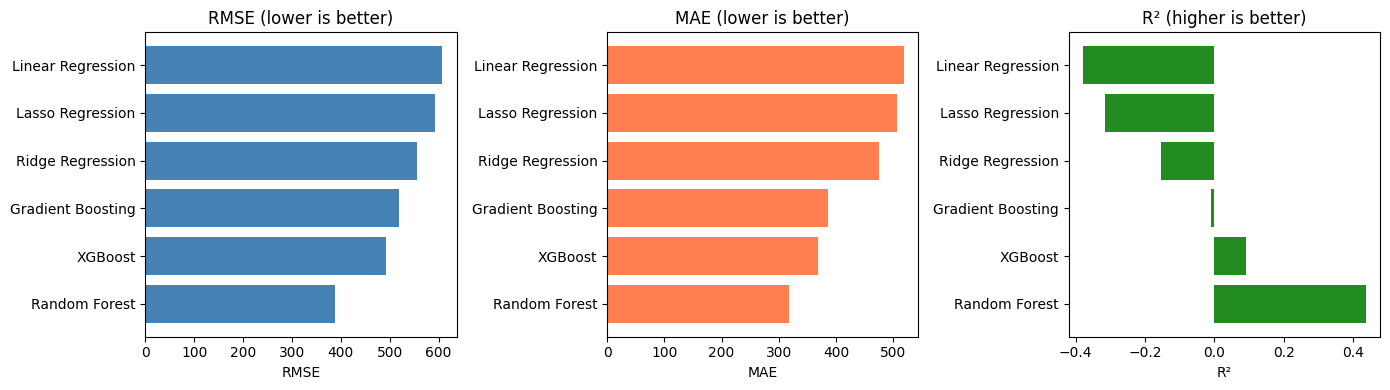

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# RMSE
axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE')
axes[0].set_title('RMSE (lower is better)')

# MAE
axes[1].barh(results_df['Model'], results_df['MAE'], color='coral')
axes[1].set_xlabel('MAE')
axes[1].set_title('MAE (lower is better)')

# R²
axes[2].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[2].set_xlabel('R²')
axes[2].set_title('R² (higher is better)')

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Best model: Random Forest


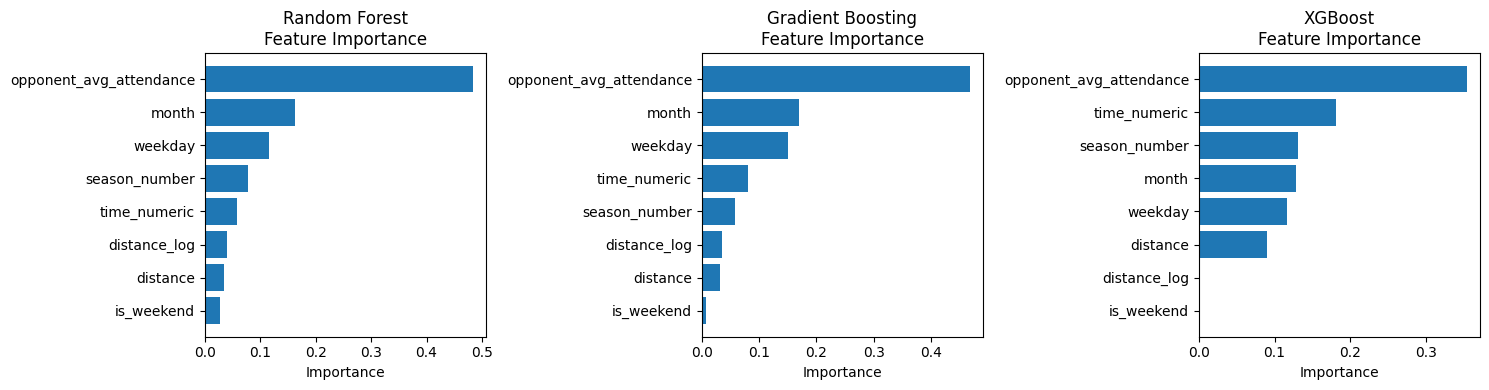

In [10]:
# Get best model name
best_model_name = results_df.iloc[0]['Model']
print(f"Best model: {best_model_name}")

# Feature importance from tree-based models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']

for ax, model_name in zip(axes, tree_models):
    model = trained_models[model_name]
    importance = model.feature_importances_
    
    # Sort by importance
    sorted_idx = np.argsort(importance)
    
    ax.barh([feature_cols[i] for i in sorted_idx], importance[sorted_idx])
    ax.set_title(f'{model_name}\nFeature Importance')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [11]:
# Coefficients from linear models (for interpretability)
print("\nLinear Model Coefficients:")
print("="*50)

for model_name in ['Ridge Regression', 'Lasso Regression']:
    model = trained_models[model_name]
    coef_df = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    print(f"\n{model_name}:")
    print(coef_df.to_string(index=False))


Linear Model Coefficients:

Ridge Regression:
                Feature  Coefficient
opponent_avg_attendance   388.559659
           distance_log   244.488217
               distance  -203.680448
                  month  -152.601619
          season_number   129.648980
             is_weekend  -125.648145
                weekday    96.277740
           time_numeric   -84.673014

Lasso Regression:
                Feature  Coefficient
           distance_log   663.859914
               distance  -588.158122
opponent_avg_attendance   435.772506
             is_weekend  -155.870013
                  month  -153.135444
          season_number   134.221883
                weekday   124.410330
           time_numeric   -75.864967


## 7. Actual vs Predicted Plot

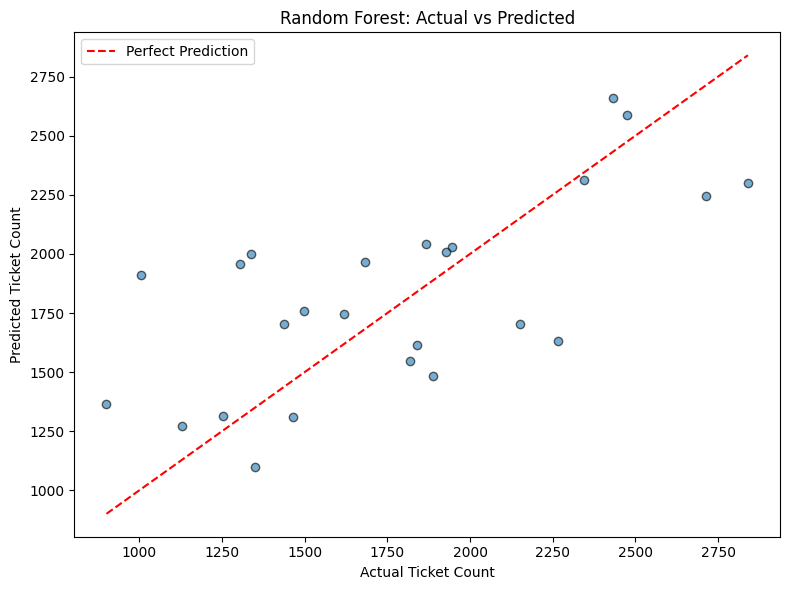


Residual Statistics for Random Forest:
Mean Residual: -42.97
Std Residual: 393.11
Max Over-prediction: -904.01
Max Under-prediction: 633.15


In [12]:
# Plot actual vs predicted for best model
best_model = trained_models[best_model_name]

# Get predictions
if best_model_name in scaled_models:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test.values)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, edgecolor='k')

# Perfect prediction line
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Ticket Count')
plt.ylabel('Predicted Ticket Count')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test - y_pred_best
print(f"\nResidual Statistics for {best_model_name}:")
print(f"Mean Residual: {residuals.mean():.2f}")
print(f"Std Residual: {residuals.std():.2f}")
print(f"Max Over-prediction: {residuals.min():.2f}")
print(f"Max Under-prediction: {residuals.max():.2f}")

## 8. Save Best Model

In [14]:
import joblib

# Save best model
model_path = f'Models/baseline_model/best_model_{best_model_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, model_path)
print(f"Saved best model to {model_path}")

# Save scaler (needed for linear models)
scaler_path = 'Models/baseline_model/feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"Saved scaler to {scaler_path}")

# Save results
results_df.to_csv('Models/baseline_model/baseline_model_results.csv', index=False)
print("Saved model comparison results")

Saved best model to Models/baseline_model/best_model_random_forest.joblib
Saved scaler to Models/baseline_model/feature_scaler.joblib
Saved model comparison results


## Summary

Models trained and evaluated on time-series split:
- Training: Seasons 22-23 & 23-24
- Testing: Season 24-25

Next steps:
1. Hyperparameter optimization for top models
2. Generate predictions for 25-26 season